**This is file to select the features to be used in the modelling of our project.**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [ ]:
df_train = pd.read_csv('cleaned_train.csv')
df_test = pd.read_csv('cleaned_test.csv')
df_train.head()

,id,budget,homepage,original_language,original_title,overview,release_date,revenue,runtime,status,...,History,Horror,Music,Mystery,Romance,Science.Fiction,Thriller,TV.Movie,War,Western
0,1004,25000000.0,NaN,en,Lonesome Jim,"Failing to make it on his own, 27-year-old Jim...",2005-11-16,38565909.0,91.0,Released,...,0,0,0,0,1,0,0,0,0,0
1,623,15000000.0,NaN,en,eXistenZ,A game designer on the run from assassins must...,1999-04-14,2856712.0,97.0,Released,...,0,1,0,0,0,1,1,0,0,0
2,2693,70000000.0,http://www.couplesretreatmovie.com/,en,Couples Retreat,"Four couples, all friends, descend on a tropic...",2009-09-19,171844840.0,113.0,Released,...,0,0,0,0,1,0,0,0,0,0
3,934,60000000.0,NaN,en,The Sentinel,A secret service agent is framed as the mole i...,2006-04-19,77920346.0,108.0,Released,...,0,0,0,0,0,0,1,0,0,0
4,4496,60000000.0,https://www.facebook.com/LondonHasFallenOfficial,en,London Has Fallen,"In London for the Prime Minister's funeral, Mi...",2016-03-02,205754447.0,99.0,Released,...,0,0,0,0,0,0,1,0,0,0


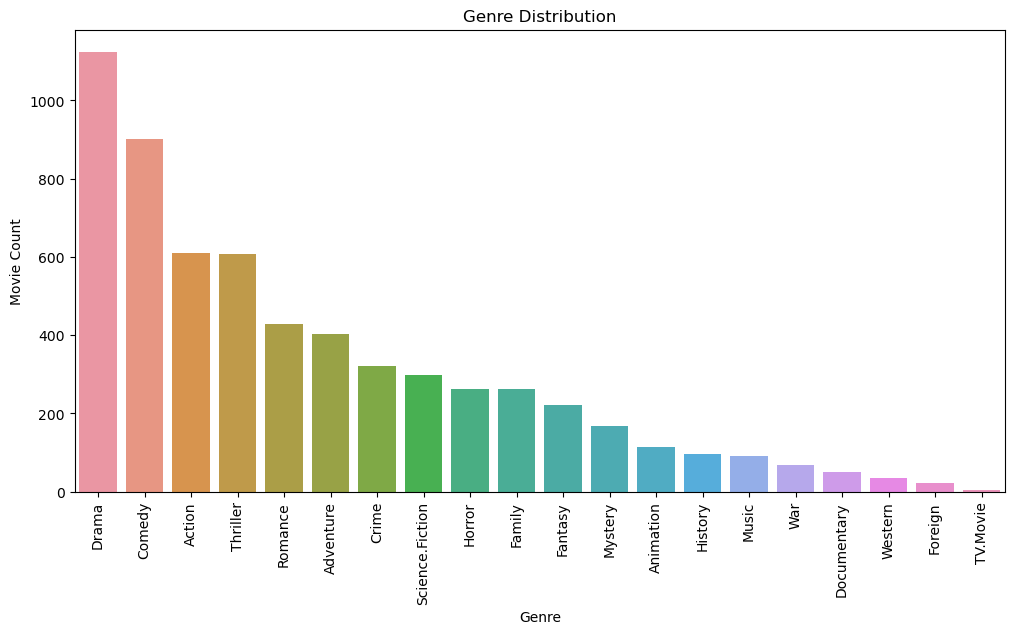

In [ ]:
# Count movie
genre_counts = df_train.iloc[:, 14:].sum().sort_values(ascending=False)

# Genre distribution
plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.title("Genre Distribution")
plt.show()


### Observation: There is IMBALANCE DATA in our dataset since genres such as Drama, Comedy, Action, Thriller dominate, while genres such as TV.Movie, Foreign, Western, Documentary are rare.

# CHECKING CORRELATION AMONG ALL FEATURES AND THE GENRES

## 1. Correlation between Numerical Features and Genres

### 1.a. Pearson Method

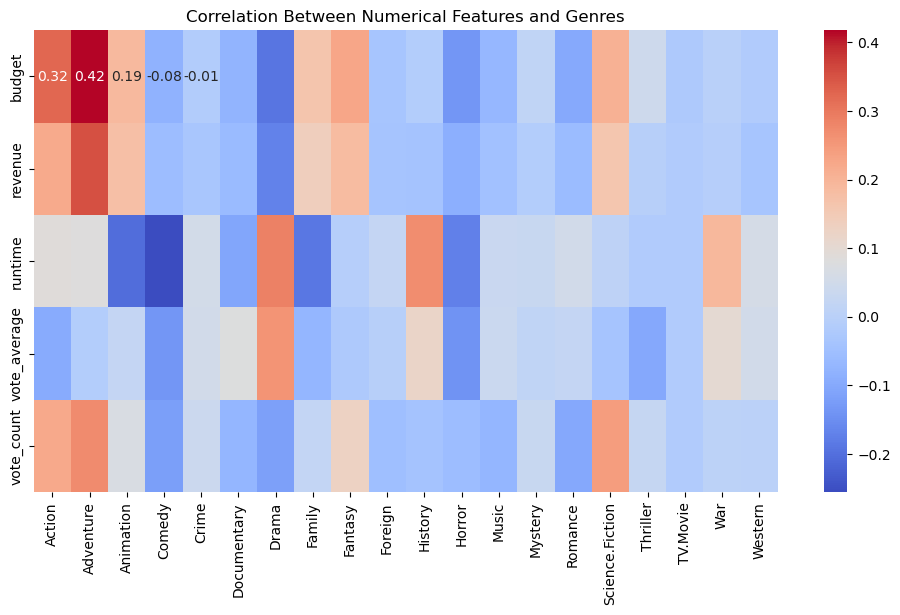

In [ ]:
# Select numerical features
num_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']
correlation_matrix = df_train[num_cols + list(df_train.columns[14:])].corr()

# Extract correlation between numerical features and genres
correlation_with_genres = correlation_matrix.iloc[:5, 5:]  # Only numerical vs genre correlation

# Plot the heatmap
plt.figure(figsize=(12,6))
sns.heatmap(correlation_with_genres, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numerical Features and Genres")
plt.show()


### Observation : Overall with Pearson Method there is WEAK (-0.2 - 0.3) correlation between the numerical features and Genre

### 1.b. Spearman Method

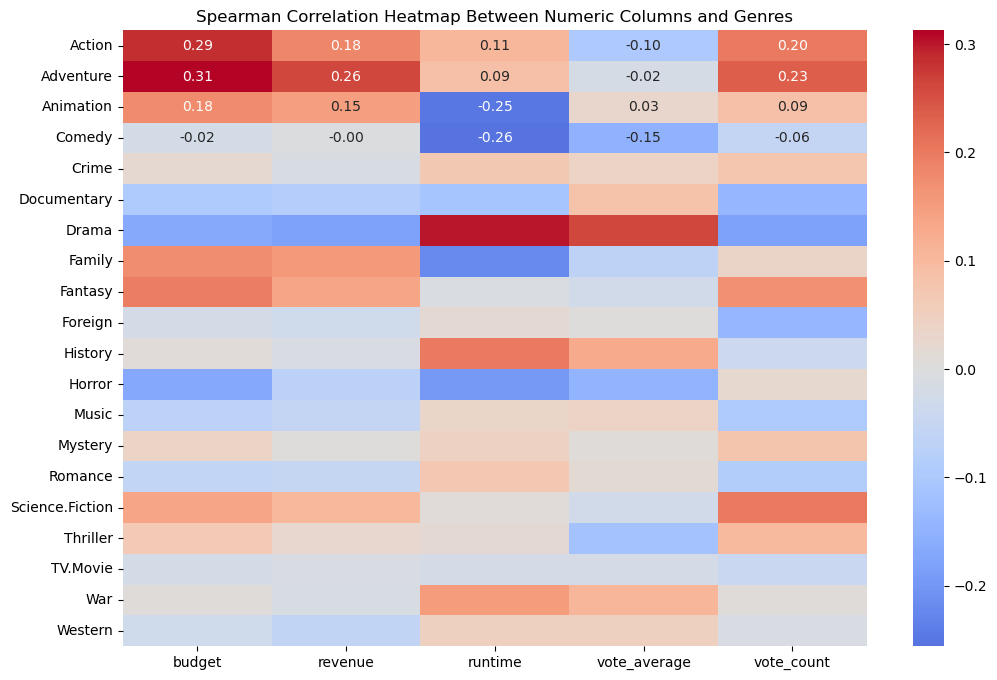

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

genre_columns = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science.Fiction', 'Thriller', 'TV.Movie',
    'War', 'Western'
]
numeric_columns = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Matrix to store Spearman correlation values
spearman_corr_matrix = pd.DataFrame(index=genre_columns, columns=numeric_columns)

# Compute Spearman correlation between numeric columns and genres
for genre in genre_columns:
    for numeric_column in numeric_columns:
        correlation = df_train[[numeric_column, genre]].corr(method='spearman').iloc[0, 1]
        spearman_corr_matrix.loc[genre, numeric_column] = correlation

# Convert data to float for heatmap processing
spearman_corr_matrix = spearman_corr_matrix.astype(float)

# Visualize with heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", cbar=True)
plt.title("Spearman Correlation Heatmap Between Numeric Columns and Genres")
plt.show()


### Observation : Overall with Spearman Method there is WEAK (-0.2 - 0.3) correlation between the numerical features and Genre

### 1.c. Cramer's V Method

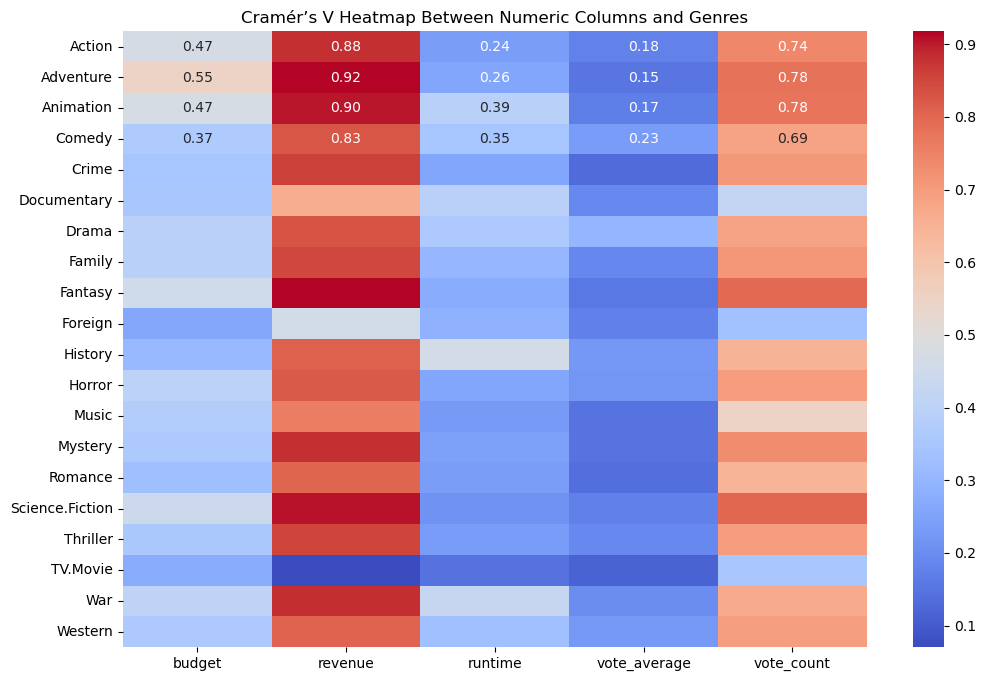

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

# Function to calculate Cramér’s V
def cramers_v(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return (chi2 / (n * (min(contingency_table.shape) - 1))) ** 0.5

# Matrix to store Cramér’s V values
cramers_v_matrix = pd.DataFrame(index=genre_columns, columns=numeric_columns)

# Calculate Cramér’s V between numeric columns and genres
for genre in genre_columns:
    for numeric_column in numeric_columns:
        contingency = pd.crosstab(df_train[numeric_column], df_train[genre])
        cramers_v_value = cramers_v(contingency)
        cramers_v_matrix.loc[genre, numeric_column] = cramers_v_value

# Convert data to float for heatmap processing
cramers_v_matrix = cramers_v_matrix.astype(float)

# Visualize with heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Cramér’s V Heatmap Between Numeric Columns and Genres")
plt.show()


### Observation : Overall with Cramer's V Method there is only STRONG (0.5-0.9) correlation on REVENUE and Genres, but WEAK correlation between the other numerical features and Genre¶

### 1.d. Kendall Tau Method

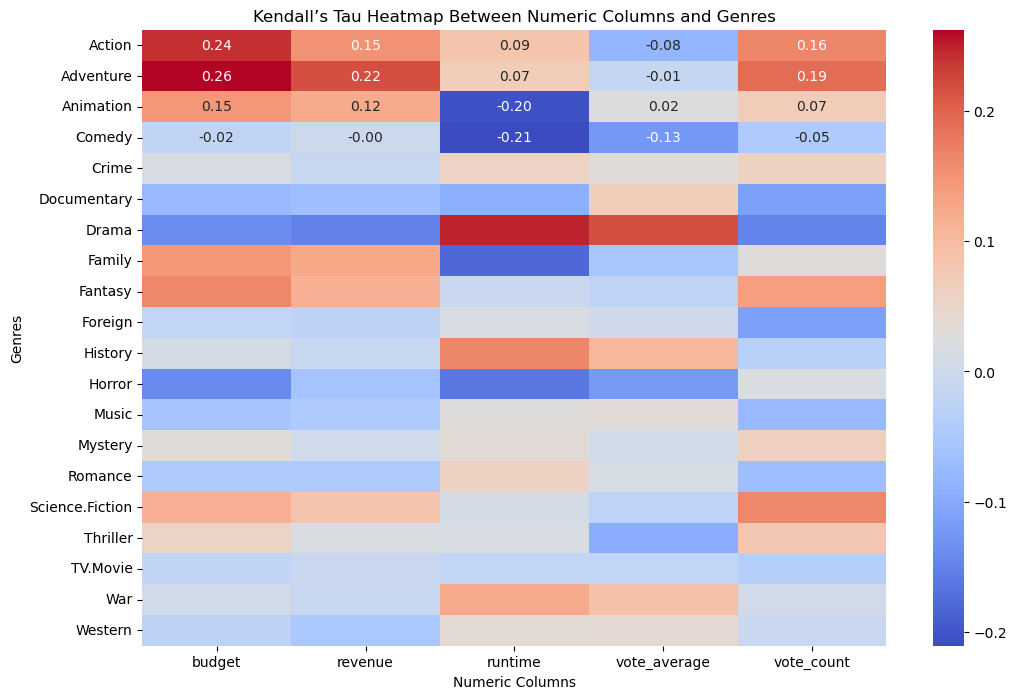

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kendalltau

# Specifying genre columns and numeric columns
genre_columns = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science.Fiction', 'Thriller', 'TV.Movie',
    'War', 'Western'
]
numeric_columns = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Matrix to store Kendall's Tau values
kendall_matrix = pd.DataFrame(index=genre_columns, columns=numeric_columns)

# Calculate Kendall's Tau between numeric columns and genres
for genre in genre_columns:
    for numeric_column in numeric_columns:
        # Using kendalltau to compute the correlation for each pair
        tau_value, _ = kendalltau(df_train[numeric_column], df_train[genre])
        kendall_matrix.loc[genre, numeric_column] = tau_value

# Convert data to float for heatmap processing
kendall_matrix = kendall_matrix.astype(float)

# Visualize with heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(kendall_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Kendall’s Tau Heatmap Between Numeric Columns and Genres")
plt.xlabel("Numeric Columns")
plt.ylabel("Genres")
plt.show()


### Observation : Overall with Kendall Tau Method there is WEAK (-0.2 - 0.2) correlation between the other numerical features and Genre¶¶

### 1.d. ANOVA P-Value Method

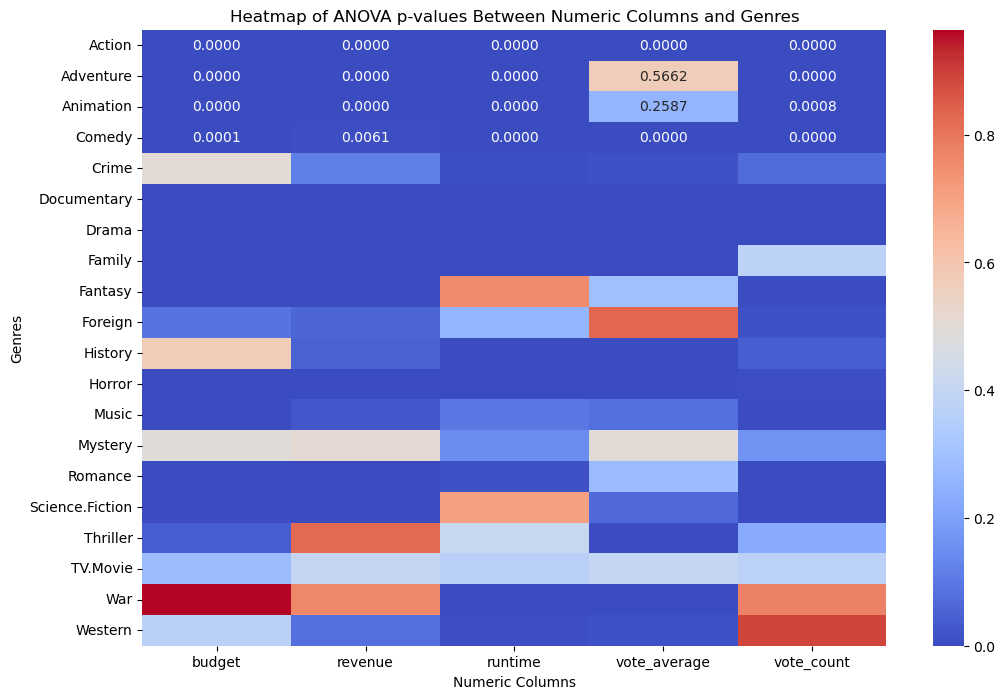

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Specifying genre columns and numeric columns
genre_columns = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science.Fiction', 'Thriller', 'TV.Movie',
    'War', 'Western'
]
numeric_columns = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Matrix to store ANOVA p-values
anova_matrix = pd.DataFrame(index=genre_columns, columns=numeric_columns)

# Calculate ANOVA p-values between numeric columns and genres
for genre in genre_columns:
    for numeric_column in numeric_columns:
        # Perform ANOVA for each genre column and numeric column
        # Assuming the genre column is binary (0 or 1) for each movie
        group1 = df_train[df_train[genre] == 1][numeric_column]
        group2 = df_train[df_train[genre] == 0][numeric_column]

        # Perform F-test (ANOVA)
        f_stat, p_value = f_oneway(group1, group2)

        # Store the p-value in the matrix
        anova_matrix.loc[genre, numeric_column] = p_value

# Convert data to float for heatmap processing
anova_matrix = anova_matrix.astype(float)

# Visualize with heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(anova_matrix, annot=True, cmap='coolwarm', fmt=".4f", cbar=True)
plt.title("Heatmap of ANOVA p-values Between Numeric Columns and Genres")
plt.xlabel("Numeric Columns")
plt.ylabel("Genres")
plt.show()



### Observation : Overall with ANOVA P-Value Method there is WEAK (over 0.05) correlation between the other numerical features and Genre¶¶

## 1.e. Mutual Information Method

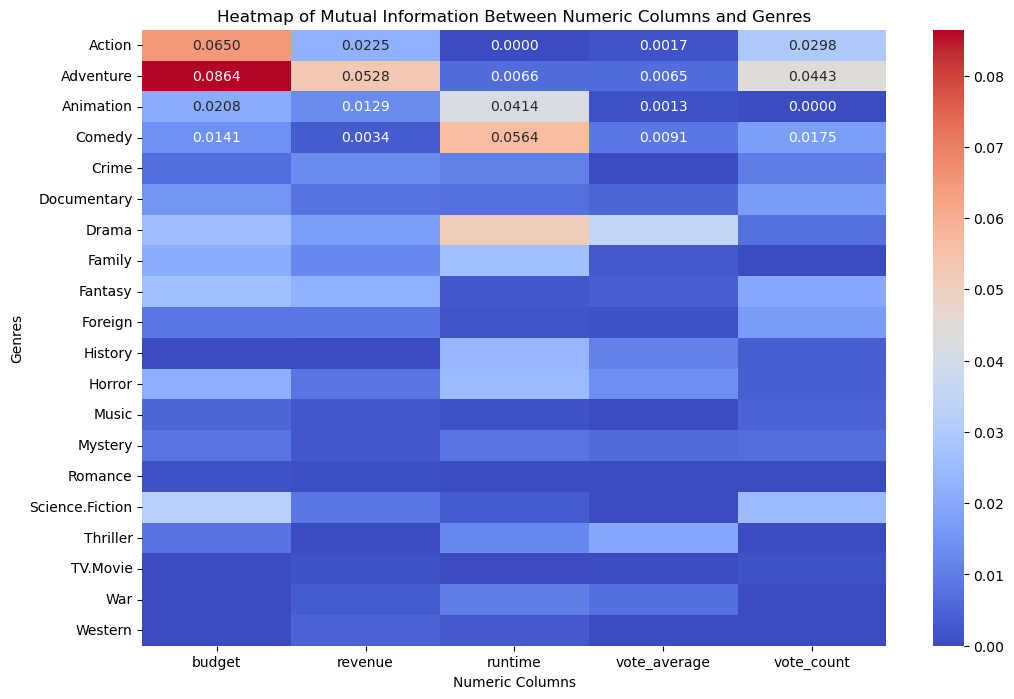

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Specifying genre columns and numeric columns
genre_columns = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science.Fiction', 'Thriller', 'TV.Movie',
    'War', 'Western'
]
numeric_columns = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Matrix to store Mutual Information values
mutual_info_matrix = pd.DataFrame(index=genre_columns, columns=numeric_columns)

# Calculate Mutual Information between numeric columns and genres
for genre in genre_columns:
    for numeric_column in numeric_columns:
        # Binning numeric data to treat as categorical data
        binned_numeric_column = pd.cut(df_train[numeric_column], bins=5, labels=False)

        # Calculate Mutual Information between binned numeric data and the genre column
        # Treat both binned numeric data and genre column as categorical
        mi_value = mutual_info_classif(df_train[[numeric_column]], df_train[genre])[0]

        # Store the Mutual Information value in the matrix
        mutual_info_matrix.loc[genre, numeric_column] = mi_value

# Convert data to float for heatmap processing
mutual_info_matrix = mutual_info_matrix.astype(float)

# Visualize with heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(mutual_info_matrix, annot=True, cmap='coolwarm', fmt=".4f", cbar=True)
plt.title("Heatmap of Mutual Information Between Numeric Columns and Genres")
plt.xlabel("Numeric Columns")
plt.ylabel("Genres")
plt.show()


### Observation : Overall with Mutual Information Method there is SUPER WEAK (0.00 - 0.08) correlation between the other numerical features and Genre¶

## 1.f. Point-Biserial Method

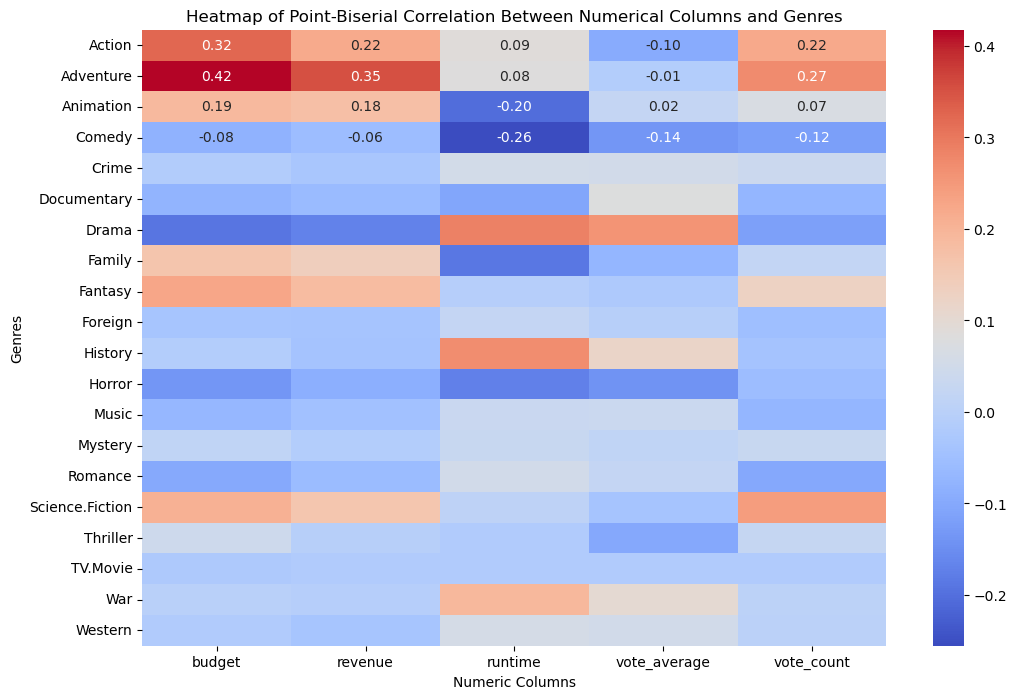

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pointbiserialr

# Specifying genre columns and numeric columns
genre_columns = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science.Fiction', 'Thriller', 'TV.Movie',
    'War', 'Western'
]
numeric_columns = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Matrix to store Point-Biserial correlation values
point_biserial_matrix = pd.DataFrame(index=genre_columns, columns=numeric_columns)

# Calculate Point-Biserial correlation between numeric columns and binary genres
for genre in genre_columns:
    for numeric_column in numeric_columns:
        # Point-Biserial correlation: assuming genre column is binary (0 or 1)
        correlation, _ = pointbiserialr(df_train[numeric_column], df_train[genre])

        # Store the correlation in the matrix
        point_biserial_matrix.loc[genre, numeric_column] = correlation

# Convert data to float for heatmap processing
point_biserial_matrix = point_biserial_matrix.astype(float)

# Visualize with heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(point_biserial_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Heatmap of Point-Biserial Correlation Between Numerical Columns and Genres")
plt.xlabel("Numeric Columns")
plt.ylabel("Genres")
plt.show()



### Observation : Overall with Point-Biserial Method there is WEAK (-0.2 - 0.4) correlation between the other numerical features and Genre¶

### CONCLUSION 1: THERE IS WEEK CORRELATION BETWEEN NUMERICAL FEATURES AND GENRES. If our goal is to use the features which have string correlation to predict the genres, they can be skipped as features.

## 2. Correlation between TEXT Features and Genres

## 2.a. Using LOG REGRESSION Method

### 2.a.1. TITLE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Function to calculate the correlation between title and genre using Logistic Regression
def calculate_title_genre_correlation_logreg(df, genre_columns):
    # Use TF-IDF to convert the title into numeric features
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # For example, take the top 1000 features
    title_tfidf = tfidf_vectorizer.fit_transform(df['title'])

    # Store the logistic regression coefficients for each genre
    logreg_results = {}

    # For each genre, train a logistic regression model and get the coefficients
    for genre in genre_columns:
        # The target is the binary genre (0 or 1)
        y = df[genre]

        # Train a Logistic Regression model
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(title_tfidf, y)

        # Get the model coefficients as a measure of correlation
        coef = logreg.coef_.flatten()

        # Calculate AUC for model evaluation
        auc = roc_auc_score(y, logreg.predict_proba(title_tfidf)[:, 1])

        # Store coefficients and AUC
        logreg_results[genre] = {'Coefficients': coef, 'AUC': auc}

    # Convert results into a DataFrame
    logreg_df = pd.DataFrame.from_dict(logreg_results, orient='index')

    # Sort genres by AUC
    logreg_df = logreg_df.sort_values(by='AUC', ascending=False)

    return logreg_df

# Calculate the correlation between title and genre using Logistic Regression
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
logreg_df = calculate_title_genre_correlation_logreg(df_train, genre_columns)

# Display the results
print(logreg_df)


                                                      Coefficients       AUC
TV.Movie         [-0.0032666711032498775, -0.006586704758404729...  0.964679
Foreign          [-0.013466177293265979, -0.02722317571568735, ...  0.955874
Documentary      [-0.03669428832910456, -0.06052740032583043, -...  0.931360
Animation        [0.31039689576656065, -0.12982753408281922, -0...  0.928896
War              [-0.04070850368531614, 0.5685825143871535, -0....  0.921313
Western          [-0.022146249048259105, 0.5772071776057, -0.02...  0.920632
Music            [-0.05306998583474489, -0.10183497304212438, -...  0.914020
Fantasy          [-0.11790387388303254, -0.23731481139615793, -...  0.906740
Family           [-0.16111468661121087, -0.26734339017842607, -...  0.902967
Horror           [0.3186310905346563, -0.2521475503372914, -0.1...  0.902204
Science.Fiction  [1.1133795787835636, 0.2018120549671123, -0.16...  0.897001
Mystery          [-0.11351644839373623, -0.20372731269709113, -...  0.890548

### Observation : Overall there is VERY STRONG CORRELATION between Title and Genres¶

### 2.a.2. TAGLINE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Function to calculate the correlation between tagline and genre using Logistic Regression
def calculate_tagline_genre_correlation_logreg(df, genre_columns):
    # Use TF-IDF to convert the tagline into numeric features
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # For example, take the top 1000 features
    tagline_tfidf = tfidf_vectorizer.fit_transform(df['tagline'].fillna(""))  # Fill NA with an empty string if necessary

    # Store the AUC results for each genre
    auc_results = {}

    # For each genre, train a Logistic Regression model and calculate AUC
    for genre in genre_columns:
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(tagline_tfidf, df[genre], test_size=0.3, random_state=42)

        # Train a Logistic Regression model
        model = LogisticRegression(solver='liblinear')
        model.fit(X_train, y_train)

        # Predict probabilities for the test data
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calculate AUC (Area Under the Curve)
        auc = roc_auc_score(y_test, y_pred_prob)
        auc_results[genre] = auc

    # Convert the results into a DataFrame and sort by AUC
    auc_df = pd.DataFrame.from_dict(auc_results, orient='index', columns=['AUC'])
    auc_df = auc_df.sort_values(by='AUC', ascending=False)

    return auc_df

# Calculate the correlation between tagline and genre using Logistic Regression
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
auc_df = calculate_tagline_genre_correlation_logreg(df_train, genre_columns)

# Display the results
print(auc_df)


                      AUC
Foreign          0.742673
Science.Fiction  0.700326
Horror           0.685453
Comedy           0.676502
Family           0.670678
Action           0.670240
History          0.660466
Documentary      0.654927
Fantasy          0.654716
Music            0.629041
War              0.621762
Adventure        0.620744
Crime            0.612354
Romance          0.608146
Thriller         0.607859
Animation        0.600042
Drama            0.598899
Mystery          0.581908
Western          0.521098
TV.Movie         0.433566


### Observation : Overall there is MODERATE TO STRONG CORRELATION between Tagline and Genres¶

### 2.a.3. OVERVIEW - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Function to calculate the correlation between overview and genre using Logistic Regression
def calculate_overview_genre_correlation_logreg(df, genre_columns):
    # Use TF-IDF to convert the overview into numeric features
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # For example, take the top 1000 features
    overview_tfidf = tfidf_vectorizer.fit_transform(df['overview'].fillna(""))  # Fill NA with an empty string if necessary

    # Store the AUC results for each genre
    auc_results = {}

    # For each genre, train a Logistic Regression model and calculate AUC
    for genre in genre_columns:
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(overview_tfidf, df[genre], test_size=0.3, random_state=42)

        # Train a Logistic Regression model
        model = LogisticRegression(solver='liblinear')
        model.fit(X_train, y_train)

        # Predict probabilities for the test data
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calculate AUC (Area Under the Curve)
        auc = roc_auc_score(y_test, y_pred_prob)
        auc_results[genre] = auc

    # Convert the results into a DataFrame and sort by AUC value
    auc_df = pd.DataFrame.from_dict(auc_results, orient='index', columns=['AUC'])
    auc_df = auc_df.sort_values(by='AUC', ascending=False)

    return auc_df

# Calculate the correlation between overview and genre using Logistic Regression
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
auc_df = calculate_overview_genre_correlation_logreg(df_train, genre_columns)

# Display the results
print(auc_df)


                      AUC
Western          0.894951
War              0.872234
History          0.868660
Documentary      0.867963
Science.Fiction  0.853622
Romance          0.853129
Horror           0.838322
Crime            0.827585
Action           0.827145
Family           0.823181
Animation        0.804084
Mystery          0.790472
Fantasy          0.771904
Adventure        0.771871
Music            0.767113
Comedy           0.751923
Thriller         0.736353
Drama            0.714607
Foreign          0.533192
TV.Movie         0.531469


### Observation : Overall there is STRONG CORRELATION between Overview and Genres¶

### 2.a.4. HOMEPAGE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Function to calculate the correlation between homepage and genre using Logistic Regression
def calculate_homepage_genre_correlation_logreg(df, genre_columns):
    # Preprocessing: fill NaN with empty string to avoid errors
    df['homepage'] = df['homepage'].fillna("")

    # Use TF-IDF to convert the homepage into numeric features
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # For example, taking the top 1000 features
    homepage_tfidf = tfidf_vectorizer.fit_transform(df['homepage'])

    # Store the AUC results for each genre
    auc_results = {}

    # For each genre, train a Logistic Regression model and calculate AUC
    for genre in genre_columns:
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(homepage_tfidf, df[genre], test_size=0.3, random_state=42)

        # Train a Logistic Regression model
        model = LogisticRegression(solver='liblinear')
        model.fit(X_train, y_train)

        # Predict probabilities for the test data
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calculate AUC (Area Under the Curve)
        auc = roc_auc_score(y_test, y_pred_prob)
        auc_results[genre] = auc

    # Convert the results into a DataFrame and sort by AUC value
    auc_df = pd.DataFrame.from_dict(auc_results, orient='index', columns=['AUC'])
    auc_df = auc_df.sort_values(by='AUC', ascending=False)

    return auc_df

# Calculate the correlation between homepage and genre using Logistic Regression
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
auc_df = calculate_homepage_genre_correlation_logreg(df_train, genre_columns)

# Display the results
print(auc_df)


                      AUC
Animation        0.664529
Documentary      0.583733
Family           0.580156
Adventure        0.575877
Drama            0.553820
History          0.551307
Crime            0.545525
Action           0.543792
Foreign          0.542020
Thriller         0.538560
Science.Fiction  0.536972
Comedy           0.536462
Music            0.526979
Romance          0.518173
Horror           0.518007
Fantasy          0.514379
Mystery          0.506685
War              0.464547
Western          0.449770
TV.Movie         0.335664


### Observation : Overall there is LOW-MODERATE CORRELATION between Homepage and Genres¶

### 2.a.5. RELEASE DATE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Function to calculate the correlation between release_date and genre using Logistic Regression
def calculate_release_date_genre_correlation_logreg(df, genre_columns):
    # Convert release_date to the number of days since the epoch (e.g., January 1, 1970)
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')  # Convert to datetime
    df['release_date'] = (df['release_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')  # Convert to number of days

    # Store AUC results for each genre
    auc_results = {}

    # For each genre, train a Logistic Regression model and calculate AUC
    for genre in genre_columns:
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(df[['release_date']], df[genre], test_size=0.3, random_state=42)

        # Train a Logistic Regression model (using multi_class='ovr' for multi-label)
        model = LogisticRegression(solver='liblinear', multi_class='ovr')
        model.fit(X_train, y_train)

        # Predict probabilities for the test data
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

        # Calculate AUC (Area Under the Curve) for multi-label
        auc = roc_auc_score(y_test, y_pred_prob)
        auc_results[genre] = auc

    # Convert the results to a DataFrame and sort by AUC value
    auc_df = pd.DataFrame.from_dict(auc_results, orient='index', columns=['AUC'])
    auc_df = auc_df.sort_values(by='AUC', ascending=False)

    return auc_df

# Calculate the correlation between release_date and genre using Logistic Regression
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
auc_df = calculate_release_date_genre_correlation_logreg(df_train, genre_columns)

# Display the results
print(auc_df)


                      AUC
Music            0.573077
Fantasy          0.558570
Comedy           0.550505
Romance          0.537792
History          0.532446
Mystery          0.525885
Adventure        0.502900
Crime            0.501385
Drama            0.500371
Horror           0.499305
Science.Fiction  0.495106
Foreign          0.493997
Family           0.492332
TV.Movie         0.492308
Western          0.489583
Thriller         0.488829
War              0.488598
Action           0.480370
Documentary      0.453589
Animation        0.387664


### Observation : Overall there is LOW-MODERATE CORRELATION between Release Date and Genres

### 2.a.6. ORIGINAL LANGUAGE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Preprocessing: Convert 'original_language' to a numeric feature
df_train['original_language'] = df_train['original_language'].fillna('Unknown')  # Fill missing values with 'Unknown'

# Use Label Encoding for 'original_language'
label_encoder = LabelEncoder()  # Initialize label encoder
df_train['original_language_encoded'] = label_encoder.fit_transform(df_train['original_language'])  # Encode 'original_language' to numeric values

# Get genre columns (assuming genre columns start from column 14 onwards)
genre_columns = df_train.columns[14:]  # Extract genre columns starting from index 14

# Store evaluation results for each genre
evaluation_results = {}

# For each genre, train a Logistic Regression model and evaluate its performance
for genre in genre_columns:
    # Use 'original_language_encoded' as the feature and the genre as the target
    X = df_train[['original_language_encoded']]  # Feature: Encoded original language
    y = df_train[genre]  # Target: Genre column

    # Split data into training and test sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a Logistic Regression model
    model = LogisticRegression(solver='liblinear')  # Initialize the logistic regression model
    model.fit(X_train, y_train)  # Train the model on the training data

    # Make predictions on the test data
    y_pred = model.predict(X_test)  # Predict the genre for the test data

    # Save the evaluation results (classification report)
    evaluation_results[genre] = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # Store performance metrics

# Convert the evaluation results to a DataFrame and display the results
evaluation_df = pd.DataFrame.from_dict(
    {genre: results['accuracy'] for genre, results in evaluation_results.items()},  # Extract accuracy from each genre's results
    orient='index', columns=['Accuracy']  # Create a DataFrame with genres as index and accuracy as the column
)

# Sort the results by accuracy in descending order
evaluation_df = evaluation_df.sort_values(by='Accuracy', ascending=False)  # Sort by accuracy

# Display the evaluation results
print(evaluation_df)  # Output the sorted accuracy results


                           Accuracy
TV.Movie                   0.998603
status_encoded             0.997207
Western                    0.988827
Foreign                    0.988827
Documentary                0.976257
War                        0.973464
Music                      0.963687
History                    0.956704
original_language_encoded  0.946927
Animation                  0.941341
Mystery                    0.931564
Fantasy                    0.910615
Horror                     0.896648
Science.Fiction            0.881285
Family                     0.874302
Crime                      0.871508
Romance                    0.839385
Adventure                  0.833799
Thriller                   0.756983
Action                     0.755587
Comedy                     0.581006
Drama                      0.539106


### Observation : Overall there is STRONG CORRELATION between ORIGINAL LANGUAGE and Genres

### CONCLUSION 2: Using Logistic Regression, we found that:

### - Title, Tagline, and Overview have strong to very strong correlation with genres.

### - Original Language also strongly predicts genre.

### - Homepage and Release Date show only low to moderate correlation.

### 👉 Textual features and language are the best predictors, while others are less useful on their own.

## 2.b. Using CRAMER'S V Method

### 2.b.1. TITLE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import chi2_contingency

# Function to compute Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Function to calculate correlation between 'title' and each genre using Cramér's V
def calculate_title_genre_correlation(df, genre_columns):
    # Convert 'title' into numerical features using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit to top 1000 features
    title_tfidf = tfidf_vectorizer.fit_transform(df['title'])

    # Store Cramér's V results for each genre
    cramers_results = {}

    # Use the most dominant TF-IDF feature per title (highest weight)
    title_features = title_tfidf.argmax(axis=1).A1  # Convert to 1D array

    # Calculate Cramér's V for each genre
    for genre in genre_columns:
        # Create a contingency table between TF-IDF feature and the genre
        contingency = pd.crosstab(df[genre], title_features)
        cramers_v_value = cramers_v(contingency)
        cramers_results[genre] = cramers_v_value

    # Convert results to DataFrame and sort by Cramér's V
    cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=["Cramér's V"])
    cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)

    return cramers_df

# Calculate the correlation between 'title' and genres
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column index 14
cramers_df = calculate_title_genre_correlation(df_train, genre_columns)

# Display results
print(cramers_df)


                           Cramér's V
Foreign                      0.718640
Animation                    0.715816
Family                       0.714776
Fantasy                      0.713248
Science.Fiction              0.711908
Horror                       0.702069
Action                       0.684782
Comedy                       0.683678
Romance                      0.679454
Adventure                    0.670498
Drama                        0.661064
Thriller                     0.659912
Crime                        0.658948
Music                        0.658878
War                          0.640344
TV.Movie                     0.631679
Western                      0.619286
Mystery                      0.619236
Documentary                  0.618640
original_language_encoded    0.585591
History                      0.577359


### Observation: The corelation between Title and Genre is HIGH (over 0.5-0.7 in all Genre)

### 2.b.2. TAGLINE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import chi2_contingency

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Function to calculate correlation between 'tagline' and each genre
def calculate_tagline_genre_correlation(df, genre_columns):
    # Convert 'tagline' into numeric features using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Top 1000 features
    tagline_tfidf = tfidf_vectorizer.fit_transform(df['tagline'].fillna(""))  # Fill NA with empty string if needed

    # Store Cramér's V values for each genre
    cramers_results = {}

    # Get the most dominant TF-IDF feature for each tagline
    tagline_features = tagline_tfidf.argmax(axis=1).A1  # Convert to 1D array

    # Calculate Cramér's V for each genre
    for genre in genre_columns:
        # Create contingency table between the dominant TF-IDF feature and the genre
        contingency = pd.crosstab(df[genre], tagline_features)
        cramers_v_value = cramers_v(contingency)
        cramers_results[genre] = cramers_v_value

    # Convert results to DataFrame and sort by Cramér's V
    cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=["Cramér's V"])
    cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)

    return cramers_df

# Calculate correlation between tagline and genre
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column index 14
cramers_df = calculate_tagline_genre_correlation(df_train, genre_columns)

# Display the results
print(cramers_df)


                           Cramér's V
Crime                        0.702253
Comedy                       0.689448
Family                       0.686195
Action                       0.677295
Fantasy                      0.674570
Mystery                      0.674529
Science.Fiction              0.673075
Horror                       0.671560
Drama                        0.669287
Adventure                    0.668559
Thriller                     0.657655
Western                      0.657653
Romance                      0.647061
Animation                    0.641803
War                          0.638177
Music                        0.610213
History                      0.599013
Foreign                      0.528830
original_language_encoded    0.491481
Documentary                  0.482808
TV.Movie                     0.323341


### Observation: The corelation between Tagline and Genre is HIGH (over 0.3-0.7 in all Genre)

### 2.b.3. OVERVIEW - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import chi2_contingency

# Cramér's V function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Function to calculate correlation between overview and genre
def calculate_overview_genre_correlation(df, genre_columns):
    # Use TF-IDF to convert overview text into numerical features
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Example: use top 1000 features
    overview_tfidf = tfidf_vectorizer.fit_transform(df['overview'].fillna(""))  # Fill missing values with empty string

    # Store Cramér's V result for each genre
    cramers_results = {}

    # Get the most dominant TF-IDF feature for each overview
    overview_features = overview_tfidf.argmax(axis=1).A1  # .A1 converts result into a 1D array

    # Calculate Cramér's V for each genre
    for genre in genre_columns:
        # Create a contingency table between dominant TF-IDF features and genre labels
        contingency = pd.crosstab(df[genre], overview_features)
        cramers_v_value = cramers_v(contingency)
        cramers_results[genre] = cramers_v_value

    # Convert results into a DataFrame and sort by Cramér's V value
    cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=["Cramér's V"])
    cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)

    return cramers_df

# Calculate the correlation between overview and genre
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
cramers_df = calculate_overview_genre_correlation(df_train, genre_columns)

# Display the results
print(cramers_df)


                           Cramér's V
Foreign                      0.675463
Crime                        0.641499
Science.Fiction              0.638323
Horror                       0.633911
Western                      0.632701
Drama                        0.625758
Thriller                     0.625337
Action                       0.625299
Adventure                    0.622461
War                          0.618135
Romance                      0.613438
Comedy                       0.612205
Family                       0.604891
Fantasy                      0.600201
Documentary                  0.595900
History                      0.589398
Animation                    0.587909
Music                        0.575744
Mystery                      0.571159
original_language_encoded    0.566301
TV.Movie                     0.505080


### Observation: The corelation between Overview and Genre is HIGH (over 0.5-0.6 in all Genre)

### 2.b.4. ORIGINAL LANGUAGE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Cramér's V function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Calculate Cramér's V for all genres
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
cramers_results = {}

for genre in genre_columns:
    contingency = pd.crosstab(df_train['original_language'], df_train[genre])
    cramers_v_value = cramers_v(contingency)
    cramers_results[genre] = cramers_v_value

# Convert results into a DataFrame and sort
cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=["Cramér's V"])
cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)

# Display results
print(cramers_df)


                           Cramér's V
original_language_encoded    1.000000
Foreign                      0.293758
History                      0.244820
War                          0.222164
Animation                    0.161799
Drama                        0.155578
Action                       0.151236
Fantasy                      0.137528
Adventure                    0.124218
Music                        0.123881
Romance                      0.113349
Comedy                       0.111008
Crime                        0.104585
Horror                       0.102904
Documentary                  0.101309
Thriller                     0.093173
Western                      0.091221
Family                       0.087257
Science.Fiction              0.081933
Mystery                      0.077416
TV.Movie                     0.011869


### Observation: The corelation between Original language and Genre is WEAK (under 0.3 in all Genre)

### 2.b.5. HOMEPAGE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import chi2_contingency

# Cramér's V function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Function to calculate correlation between homepage and genre
def calculate_homepage_genre_correlation(df, genre_columns):
    # Preprocessing: fill NaN with empty string to avoid errors
    df['homepage'] = df['homepage'].fillna("")

    # Use TF-IDF to convert homepage text into numerical features
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    homepage_tfidf = tfidf_vectorizer.fit_transform(df['homepage'])

    # Store Cramér's V results for each genre
    cramers_results = {}

    # Get most prominent TF-IDF feature per homepage
    homepage_features = homepage_tfidf.argmax(axis=1).A1  # .A1 converts to 1D array

    # For each genre, compute Cramér's V
    for genre in genre_columns:
        contingency = pd.crosstab(df[genre], homepage_features)
        cramers_v_value = cramers_v(contingency)
        cramers_results[genre] = cramers_v_value

    # Convert results into a DataFrame and sort
    cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=["Cramér's V"])
    cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)

    return cramers_df

# Calculate correlation between homepage and genres
genre_columns = df_train.columns[14:]  # Assuming genre columns start at column 14
cramers_df = calculate_homepage_genre_correlation(df_train, genre_columns)

# Show results
print(cramers_df)


                           Cramér's V
Animation                    0.753360
Documentary                  0.712110
original_language_encoded    0.656426
Family                       0.643759
Adventure                    0.634840
TV.Movie                     0.632392
Fantasy                      0.631099
Science.Fiction              0.621356
Western                      0.600901
Crime                        0.582231
Action                       0.582135
Comedy                       0.571381
Drama                        0.569534
Mystery                      0.564773
Thriller                     0.559061
Horror                       0.548084
War                          0.540502
Foreign                      0.535371
History                      0.535354
Romance                      0.529751
Music                        0.484420


### Observation: The corelation between Homepage and Genre is HIGH (over 0.4-0.7 in all Genre)¶

### 2.b.6. STATUS - GENRES

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Cramér's V function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Function to calculate correlation between status and genre
def calculate_status_genre_correlation(df, genre_columns):
    # Convert status into numeric categories
    df['status'] = pd.Categorical(df['status']).codes

    # Store Cramér's V results for each genre
    cramers_results = {}

    # Calculate Cramér's V for each genre
    for genre in genre_columns:
        # Create contingency table between status and genre
        contingency = pd.crosstab(df[genre], df['status'])
        cramers_v_value = cramers_v(contingency)
        cramers_results[genre] = cramers_v_value

    # Convert results into DataFrame and sort by Cramér's V value
    cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=["Cramér's V"])
    cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)

    return cramers_df

# Calculate correlation between status and genres
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
cramers_df = calculate_status_genre_correlation(df_train, genre_columns)

# Display the result
print(cramers_df)


                           Cramér's V
Documentary                  0.095898
Thriller                     0.038632
Drama                        0.021743
Action                       0.020794
Comedy                       0.017544
Romance                      0.016589
Adventure                    0.015995
Crime                        0.014014
Science.Fiction              0.013430
Horror                       0.012488
Family                       0.012462
Fantasy                      0.011364
Mystery                      0.009765
Animation                    0.007984
History                      0.007304
Music                        0.007025
original_language_encoded    0.006498
War                          0.006123
Western                      0.004392
Foreign                      0.003343
TV.Movie                     0.001626


### Observation: The corelation between Status and Genre is SUPER WEAK (under 0.09 in all Genre)¶

### 2.b.7. RELEASE DATE - GENRES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import chi2_contingency

# Cramér's V function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Function to calculate correlation between release_date and genre
def calculate_release_date_genre_correlation(df, genre_columns):
    # Convert release_date to number of days since Unix epoch (e.g., January 1, 1970)
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_date'] = (df['release_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

    # Store Cramér's V results for each genre
    cramers_results = {}

    # Calculate Cramér's V for each genre
    for genre in genre_columns:
        # Create a contingency table between release_date and genre
        contingency = pd.crosstab(df[genre], df['release_date'])
        cramers_v_value = cramers_v(contingency)
        cramers_results[genre] = cramers_v_value

    # Convert results to DataFrame and sort by Cramér's V
    cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=["Cramér's V"])
    cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)

    return cramers_df

# Calculate correlation between release_date and genres
genre_columns = df_train.columns[14:]  # Assuming genre columns start from column 14
cramers_df = calculate_release_date_genre_correlation(df_train, genre_columns)

# Display the results
print(cramers_df)


                           Cramér's V
Western                      0.147897
original_language_encoded    0.110031
Music                        0.104450
War                          0.078319
History                      0.070859
Thriller                     0.045462
Drama                        0.044447
Science.Fiction              0.039195
Comedy                       0.036066
Action                       0.033240
Romance                      0.021960
Fantasy                      0.017767
Animation                    0.016460
Horror                       0.016451
Family                       0.016267
Documentary                  0.013919
Adventure                    0.009416
Mystery                      0.004427
Foreign                      0.000000
Crime                        0.000000
TV.Movie                     0.000000


### Observation: The corelation between Release Date and Genre is WEAK (over 0.0-0.1 in all Genre)¶

### CONCLUSION 3: Based on Cramér’s V Correlation Analysis
### - Title, Overview, and Tagline strongly correlate with genre, indicating these features are significant for genre prediction.

### - Homepage shows some relationship with genre, possibly reflecting marketing strategies linked to genre.

### - Original Language, Status, and Release Date have minimal impact on genre classification.

### 👉 Textual features (title, overview, tagline) for more accurate genre prediction, while metadata features have limited value.


## Final Conclusion:
### - Numerical Features: There is weak correlation between numerical features and genres. These features can be excluded from the model if the goal is to focus on strong predictors.
### - Textual Features: Title, Tagline, and Overview show strong to very strong correlation with genres, making them highly valuable for genre prediction. These are the best predictors based on our analysis.
### - Original Language: It has a moderate to strong correlation with genres, indicating it is also a useful feature for predicting genres.
### - Homepage and Release Date: These show only low to moderate correlation, and their predictive power is limited on their own.

## Final Insight: Textual features (title, tagline, overview) and language are the most significant predictors for genre classification, while metadata features (homepage, release date, status) provide limited value.

## MODEL SELECTION

Since the text becomes the strongest feature, on the next step, I try several methods to classify the multi-genres such as:


1. Text (TF-IDF) + (Logistic Regression, Random Forest, MLP, SVC
2. Text (BERT) + (Logistic Regression, Random Forest, MLP, SVC)

3. Text (combined BERT and TF-IDF) + (Logistic Regression, Random Forest, MLP, SVC)

4. Text (TF-IDF) and Revenue + (Logistic Regression, Random Forest, MLP, SVC)

5. Text (Nomic AI) + (Logistic Regression, Random Forest, MLP, SVC)

6. Text (combined Nomic AI and TF-IDF) + (Logistic Regression, Random Forest, MLP, SVC)



